In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.layers import Dropout

In [2]:
# 載入資料
#data = pd.read_csv("/kaggle/input/stock-10years/BTC.csv")
#data = pd.read_csv("/kaggle/input/stock-10years/SPX.csv")
data = pd.read_csv("/kaggle/input/stock-10years/TSLA.csv")

data = data.iloc[::-1].reset_index(drop=True)
data.head()
data['Date'] = pd.to_datetime(data['Date'])
# 提取特徵
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data = data.drop('Date', axis=1)

# data['Vol.'] = data['Vol.'].str.replace('M', '', regex=False).astype(float) * 1e6
# data['Vol.'] = data['Vol.'].str.replace('K', '', regex=False).astype(float) * 1e3
data['Change %'] = data['Change %'].str.replace('%', '', regex=False).astype(float)
# data['Price'] = data['Price'].str.replace(',', '').astype(float)
# data['High'] = data['High'].str.replace(',', '').astype(float)

In [3]:
# 選擇所有特徵
# features = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'DayOfWeek']
# features = ['Vol.', 'DayOfWeek']
#features = ['DayOfWeek']
features = ['DayOfWeek', 'month', 'day', 'Price']
target = 'Price'

In [4]:
# 資料縮放
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data[features + [target]])

In [5]:
# 創建滾動窗口
window_size = 50
future_steps = 5  # 設定多步預測的步數
X, y = [], []
for i in range(len(scaled_data) - window_size - future_steps + 1):
    X.append(scaled_data[i:i + window_size, :-1])  # 使用所有特徵
    y.append(scaled_data[i + window_size:i + window_size + future_steps, -1])  # 多步價格預測

X, y = np.array(X), np.array(y)

In [6]:
# 分割資料
test_size = 30
split_index = len(data) - test_size - window_size - future_steps + 1
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [7]:
# 重塑 X 以適應 LSTM 的輸入格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


num_features = X_train.shape[2]

def train_multiple_models(X_train, y_train, future_steps):
    models = []
    for step in range(future_steps):
        model = Sequential([
            LSTM(64, input_shape=(window_size, num_features), return_sequences=False),
            Dropout(0.2),
            Dense(1)  # 單步預測
        ])
        model.compile(optimizer='adam', loss='mse')

        # y_train[:, step]: 提取當前步的目標值
        y_train_step = y_train[:, step]
        model.fit(X_train, y_train_step, epochs=50, batch_size=32, validation_split=0.2)
        models.append(model)
    return models

models = train_multiple_models(X_train, y_train, future_steps)
# 建立 LSTM 模型
# model = Sequential()
# model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(future_steps))  # 多步輸出層

# def train_single_model(X_train, y_train, future_steps):
#     model = Sequential([
#         LSTM(units=64, return_sequences=True, input_shape=(window_size, num_features)),
#         Dropout(0.2),
#         LSTM(units=64, return_sequences=True),
#         Dropout(0.2),
#         LSTM(units=64, return_sequences=False),
#         Dropout(0.2),
#         Dense(future_steps)  # 多步輸出
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
#     return model

# # 訓練單一模型
# single_model = train_single_model(X_train, y_train, future_steps)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1754 - val_loss: 0.0076
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - val_loss: 0.0087
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0076
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0066
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_l

In [8]:
# # 編譯模型
# optimizer = Adam(learning_rate=0.005)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# # 訓練模型
# model.fit(X_train, y_train, epochs=50, batch_size=128)

In [9]:
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (30, 50, 4)
y_test shape: (30, 5)


In [10]:
#64 0.2 64 0.2 0.001 

In [11]:
# 初始化列表用於存放每個模型的預測結果
predictions = []

# 遍歷每個模型並進行預測
for model in models:
    prediction = model.predict(X_test)  # 每個模型對應一個步驟
    predictions.append(prediction)

predictions = np.squeeze(np.array(predictions)).T

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


MAPE: 6.70%


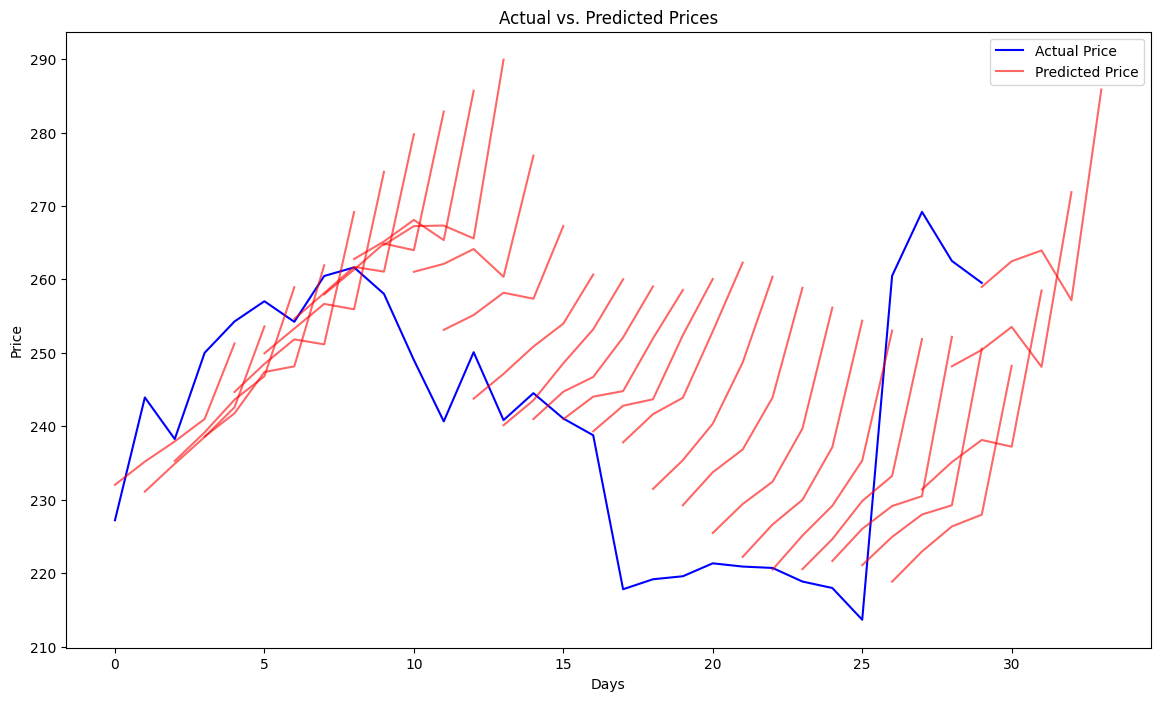

In [12]:
# 保存 Price 的最小值和最大值
price_min = data['Price'].min()
price_max = data['Price'].max()

# 反轉縮放 - 真實值和預測值
actual = price_min + (y_test + 1) * 0.5 * (price_max - price_min)
predicted_scaled = price_min + (predictions + 1) * 0.5 * (price_max - price_min)

mape = mean_absolute_percentage_error(actual, predicted_scaled) * 100
print(f"MAPE: {mape:.2f}%")

# 繪製實際值
plt.figure(figsize=(14, 8))
plt.plot(actual[:, 0], label="Actual Price", color="blue")  # 實際價格作為基準曲線

# 繪製預測值
for i in range(predicted_scaled.shape[0]):
    plt.plot(
        range(i, i + future_steps),
        predicted_scaled[i, :],
        color="red",
        alpha=0.6,
        label="Predicted Price" if i == 0 else "",
    )

# 添加標題和圖例
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()
